# Experiments

## Data Preparation

Using file `data_prep.py` for preparing the data in the same way like `eda.ipynb`. The function combines posts from multiple sources: 
- the combined dataset (df),
- posts on the homepage (df_homepage),
- posts identified as potentially misinforming (df_misinfo).

In [1]:
from data_prep import prepare_data
import numpy as np

# Optional: reproducible fuzzy scores
np.random.seed(42)

df, df_homepage, df_misinfo = prepare_data(
    id_file=r"../data/final_combined_results_2937495-7229337.json",
    homepage_file=r"../data/homepage_posts_data.json",
    misinfo_file=r"../data/mssinfo_wykop_posts.json",
)

print(df.shape, df_homepage.shape, df_misinfo.shape)
print(df[['text', 'scores', 'scores_fuzzy']].head())

(12259, 10) (9863, 9) (2832, 12)
                                                text  scores  scores_fuzzy
0  We Francji spokojnie. W sylwestra spalono tylk...     1.0      0.989100
1  [Afera Prezydencka] Moderator fDy A gdyby tak ...     1.0      0.998437
2  Szczera wypowiedź Tomasza Lisa pan redaktor w ...     1.0      1.000000
3  Inwazja zombie-islamu na Europę stała się fakt...     1.0      1.000000
4  Czy tak wyglądały ataki w Koloni  w Nowy Rok? ...     1.0      1.000000


The resulting shapes indicate that the primary dataset contains 12,259 entries, with the homepage and misinformation subsets containing 9,863 and 2,832 entries, respectively.

Then the scores are discretized into three categories representing the likelihood of a post being fake news where:
- 0 for likely genuine posts,
- 1 for uncertain,
- 2 for the possibility of the post being fake news
Duplicate entries are removed based on `clean_text` to avoid bias in the model. 

In [2]:
rounding_conditions = [
    df['scores'] < 0.35,
    (df['scores'] >= 0.35) & (df['scores'] < 0.85),
    df['scores'] >= 0.85
]

rounding_choices = [0, 0.7, 1]

df['scores'] = np.select(rounding_conditions, rounding_choices)


In [3]:
# For classification - 3 classes
df["label"] = df["scores"].apply(lambda x: 0 if x < 0.35 else (2 if x > 0.85 else 1))

df = df[~df['clean_text'].duplicated()].reset_index(drop=True)
df["label"].value_counts(normalize=True)

label
0    0.578320
2    0.227071
1    0.194609
Name: proportion, dtype: float64

The class distribution shows that most posts are genuine (about 58%) with fewer uncertain and suspecting of being fake.

To test the binary classification variant, two classes are created, where class 0 contains only genuine posts, and class 1 contains uncertain posts and posts suspected of being fake news.

In [4]:
# For classification - 2 classes
df_2c = df.copy()
df_2c["label"] = df_2c["scores"].apply(lambda x: 0 if x == 0 else 1)

df_2c = df_2c[~df_2c['clean_text'].duplicated()].reset_index(drop=True)
df_2c["label"].value_counts(normalize=True)

label
0    0.57832
1    0.42168
Name: proportion, dtype: float64

The class distribution is relatively balanced, with genuine posts making up about 58% and potentially fake posts about 42%.

## Experiments

In [5]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.utils import resample

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

TF-IDF vectorization is applied to convert the raw text into numerical features and limit the vocabulary to frequent and informative terms. The datasets are split into training and validation sets with stratification to preserve class distributions.
There is also a feature space limit of 7000 dimensions.

In [15]:
y_2c = df_2c['label']
y = df['label']

vectorizer_3c = TfidfVectorizer(max_features=7000, ngram_range=(1,2), min_df=3, max_df=0.9)
X_train_text_3c, X_val_text_3c, y_train_3c, y_val_3c = train_test_split(
    df["text"],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train_tfidf_3c = vectorizer_3c.fit_transform(X_train_text_3c)
X_val_tfidf_3c   = vectorizer_3c.transform(X_val_text_3c)

vectorizer_2c = TfidfVectorizer(max_features=7000, ngram_range=(1,2), min_df=3, max_df=0.9)
X_train_text_2c, X_val_text_2c, y_train_2c, y_val_2c = train_test_split(
    df_2c["text"],
    y_2c,
    test_size=0.2,
    random_state=42,
    stratify=y_2c
)
X_train_tfidf_2c = vectorizer_2c.fit_transform(X_train_text_2c)
X_val_tfidf_2c   = vectorizer_2c.transform(X_val_text_2c)## Embedding

### Embedding

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Text data is tokenized and converted into sequences of integer indices. We limited the vocabulary to the most frequent 7000 words and used a special token for out-of-vocabulary terms. 
Stratified train-validation splits maintain the original class distributions in both datasets.

In [17]:
VOCAB_SIZE = 7000
MAX_LENGTH = 75

X_train_text_3c, X_val_text_3c, y_train_3c, y_val_3c = train_test_split(
    df["clean_text"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)
tokenizer_3c = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_3c.fit_on_texts(X_train_text_3c)

X_train_seq_3c = tokenizer_3c.texts_to_sequences(X_train_text_3c)
X_val_seq_3c   = tokenizer_3c.texts_to_sequences(X_val_text_3c)
X_train_embed_3c = pad_sequences(X_train_seq_3c, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_val_embed_3c   = pad_sequences(X_val_seq_3c,   maxlen=MAX_LENGTH, padding='post', truncating='post')


X_train_text_2c, X_val_text_2c, y_train_2c, y_val_2c = train_test_split(
    df_2c["clean_text"],
    df_2c["label"],
    test_size=0.2,
    random_state=42,
    stratify=df_2c["label"]
)
tokenizer_2c = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_2c.fit_on_texts(X_train_text_2c)

X_train_seq_2c = tokenizer_2c.texts_to_sequences(X_train_text_2c)
X_val_seq_2c   = tokenizer_2c.texts_to_sequences(X_val_text_2c)
X_train_embed_2c = pad_sequences(X_train_seq_2c, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_val_embed_2c   = pad_sequences(X_val_seq_2c,   maxlen=MAX_LENGTH, padding='post', truncating='post')

### Resampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

Random undersampling is applied to address class imbalance in both datasets. It reduces the number of samples from majority classes to match minority classes. 
The printed counts show the distribution before and after resampling.

In [19]:
print("TF_IDF\n")

rus = RandomUnderSampler(random_state=42)
X_train_tfidf_3c_res, y_train_3c_res = rus.fit_resample(X_train_tfidf_3c, y_train_3c)
print("3-class before:", y_train_3c.value_counts().to_dict())
print("3-class after:", pd.Series(y_train_3c_res).value_counts().to_dict())

X_train_tfidf_2c_res, y_train_2c_res = rus.fit_resample(X_train_tfidf_2c, y_train_2c)
print("\n2-class before:", y_train_2c.value_counts().to_dict())
print("2-class after:", pd.Series(y_train_2c_res).value_counts().to_dict())

TF_IDF

3-class before: {0: 5630, 2: 2210, 1: 1894}
3-class after: {0: 1894, 1: 1894, 2: 1894}

2-class before: {0: 5629, 1: 4105}
2-class after: {0: 4105, 1: 4105}


For the 3-class dataset, the majority class was reduced from 5630 samples to 1894, matching the counts of the minority classes (the first one). Similarly, in the 2-class dataset, the majority class was reduced from 5629 to 4105 to match the minority class.

The same operation is executed for the embeddings variant.

In [20]:
print("Embeddings\n")

X_train_embed_3c_res, y_train_embed_3c_res = rus.fit_resample(X_train_embed_3c, y_train_3c)
print("3-class before:", y_train_3c.value_counts().to_dict())
print("3-class after:", pd.Series(y_train_embed_3c_res).value_counts().to_dict())

X_train_embed_2c_res, y_train_embed_2c_res = rus.fit_resample(X_train_embed_2c, y_train_2c)
print("\n2-class before:", y_train_2c.value_counts().to_dict())
print("2-class after:", pd.Series(y_train_embed_2c_res).value_counts().to_dict())

Embeddings

3-class before: {0: 5630, 2: 2210, 1: 1894}
3-class after: {0: 1894, 1: 1894, 2: 1894}

2-class before: {0: 5629, 1: 4105}
2-class after: {0: 4105, 1: 4105}


### Training

In [22]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

Here are defined the hyperparameter configurations for several models used in the experiments.

- for the Ridge regression model, different regularization strengths `alphas` are explored to control overfitting by penalizing large coefficients,
- logistic regression is tested with varying inverse regularization strengths `Cs`,
- the XGBoost model considers combinations of tree depth (max_depths) and the number of boosting iterations `n_estimators`,
- the multi-layer perceptron network explores different hidden layer structures, learning rates, and maximum iterations.

In [23]:
model_configs = {
    "Ridge": {"alphas": [0.1, 1.0, 10.0]},
    "Logistic": {"Cs": [0.1, 1.0, 10.0]},
    "XGBoost": {"max_depths": [3, 5], "n_estimators": [50, 100]},
    "MLP": {"hidden_layer_sizes": [(64,), (128,64)], "learning_rate_init": [0.001, 0.01], "max_iter": [300, 500]}
}

This function trains a given model on the provided training data and evaluates its performance on both training and validation sets. Predictions are generated for both sets and a detailed classification report is produced for the validation data, including:
- precision,
- recall,
- F1-scores.

In [26]:
def fit_model(model, X_train, y_train, X_val, y_val, model_name, params, label_type):
    if params:
        model.set_params(**params)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    report = classification_report(
        y_val, 
        y_pred_val, 
        target_names=[str(c) for c in sorted(np.unique(y_val))],
        digits=3
    )

    print(f"{model_name} ({label_type}) {params}")
    print(report)
    return {
        "model": model_name,
        "params": params,
        "train_acc": accuracy_score(y_train, y_pred_train),
        "val_acc": accuracy_score(y_val, y_pred_val),
        "classification_report": report,
        "label_type": label_type
    }

A set of models is evaluated across a range of hyperparameter combinations, with input features scaled to ensure comparability. Ridge, Logistic, XGBoost, and MLP classifiers are considered, each exploring multiple configurations to assess their effect on predictive performance.

The process of training and evaluating is accelerated using parallel execution. 

In [27]:
def run_experiments(X_train, X_val, y_train, y_val, label_type="3-class"):
    results = []
    scaler = StandardScaler(with_mean=False) if hasattr(X_train, "toarray") else StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    tasks = []
    for model_name, params in model_configs.items():
        if model_name == "Ridge":
            for alpha in params["alphas"]:
                clf = RidgeClassifier(alpha=alpha)
                tasks.append((clf, X_train_scaled, y_train, X_val_scaled, y_val, model_name, {"alpha": alpha}, label_type))
        elif model_name == "Logistic":
            for C in params["Cs"]:
                clf = LogisticRegression(C=C, max_iter=1000)
                tasks.append((clf, X_train_scaled, y_train, X_val_scaled, y_val, model_name, {"C": C}, label_type))
        elif model_name == "XGBoost":
            for depth in params["max_depths"]:
                for n_est in params["n_estimators"]:
                    clf = XGBClassifier(max_depth=depth, n_estimators=n_est, eval_metric='mlogloss', n_jobs=-1)
                    tasks.append((clf, X_train, y_train, X_val, y_val, model_name, {"max_depth": depth, "n_estimators": n_est}, label_type))
        elif model_name == "MLP":
            for hls in params["hidden_layer_sizes"]:
                for lr in params["learning_rate_init"]:
                    for mi in params["max_iter"]:
                        clf = MLPClassifier(hidden_layer_sizes=hls, learning_rate_init=lr, max_iter=mi)
                        tasks.append((clf, X_train_scaled, y_train, X_val_scaled, y_val, model_name, 
                                      {"hidden_layer_sizes": hls, "learning_rate_init": lr, "max_iter": mi}, label_type))
    
    results = Parallel(n_jobs=-1)(delayed(fit_model)(*t) for t in tqdm(tasks, desc=f"Running experiments ({label_type})"))
    
    return results

Here are the results of the experiments.

In [28]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tqdm import tqdm

results_tfidf_3c = run_experiments(X_train_tfidf_3c_res, X_val_tfidf_3c, y_train_3c_res, y_val_3c, label_type="3-class")
results_tfidf_2c = run_experiments(X_train_tfidf_2c_res, X_val_tfidf_2c, y_train_2c_res, y_val_2c, label_type="2-class")
results_embed_3c = run_experiments(X_train_embed_3c_res, X_val_embed_3c, y_train_embed_3c_res, y_val_3c, label_type="3-class")
results_embed_2c = run_experiments(X_train_embed_2c_res, X_val_embed_2c, y_train_embed_2c_res, y_val_2c, label_type="2-class")

Running experiments (2-class): 100%|█████████████████████████████████████████████████| 18/18 [00:00<00:00, 3588.79it/s]


The experiments are then collected. The results are saved to the file `experiments_part1.csv`.

In [29]:
all_results = results_tfidf_3c + results_tfidf_2c + results_embed_3c + results_embed_2c
results_df = pd.DataFrame(all_results)

results_df.to_csv("experiments_part1.csv", index=False)

The process highlights the top-performing model for a given label type and feature set. It provides testing metrics and a classification report.

In [30]:
def plot_confusion(label_type, X_train, X_val, y_train, y_val, feature_type):
    subset = results_df[results_df['label_type'] == label_type]
    best_row = subset.loc[subset['val_acc'].idxmax()]
    model_name = best_row['model']
    params = best_row['params']

    scaler = StandardScaler(with_mean=False) if hasattr(X_train, "toarray") else StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    if model_name == "Ridge":
        clf = RidgeClassifier(**params)
    elif model_name == "Logistic":
        clf = LogisticRegression(max_iter=1000, **params)
    elif model_name == "XGBoost":
        clf = XGBClassifier(eval_metric="mlogloss", n_jobs=-1, **params)
    elif model_name == "MLP":
        clf = MLPClassifier(**params)

    if model_name in ["Ridge", "Logistic", "MLP"]:
        X_train_used = X_train_scaled
        X_val_used = X_val_scaled
    else:
        X_train_used = X_train
        X_val_used = X_val

    clf.fit(X_train_used, y_train)
    y_pred = clf.predict(X_val_used)

    print(f"Best model ({label_type}, {feature_type}): {model_name}, params: {params}")
    print("Classification report:")
    print(classification_report(
        y_val, 
        y_pred, 
        target_names=[str(c) for c in sorted(np.unique(y_val))],
        digits=3
    ))

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=sorted(np.unique(y_val)),
        yticklabels=sorted(np.unique(y_val))
    )
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.title(f"Confusion Matrix ({label_type} - {feature_type}) - {model_name}")
    plt.show()

The function is then called for four variants, two 3-class models and a 2-class model (TF-IDF and Embeddings).

Best model (3-class, TF-IDF): XGBoost, params: {'max_depth': 3, 'n_estimators': 100}
Classification report:
              precision    recall  f1-score   support

           0      0.723     0.518     0.604      1407
           1      0.290     0.532     0.375       474
           2      0.625     0.629     0.627       553

    accuracy                          0.546      2434
   macro avg      0.546     0.560     0.535      2434
weighted avg      0.616     0.546     0.565      2434



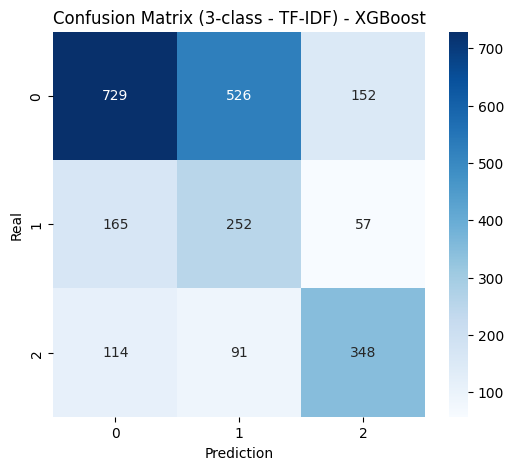

Best model (3-class, Embeddings): XGBoost, params: {'max_depth': 3, 'n_estimators': 100}
Classification report:
              precision    recall  f1-score   support

           0      0.621     0.333     0.433      1407
           1      0.242     0.466     0.319       474
           2      0.335     0.465     0.389       553

    accuracy                          0.389      2434
   macro avg      0.399     0.421     0.380      2434
weighted avg      0.482     0.389     0.401      2434



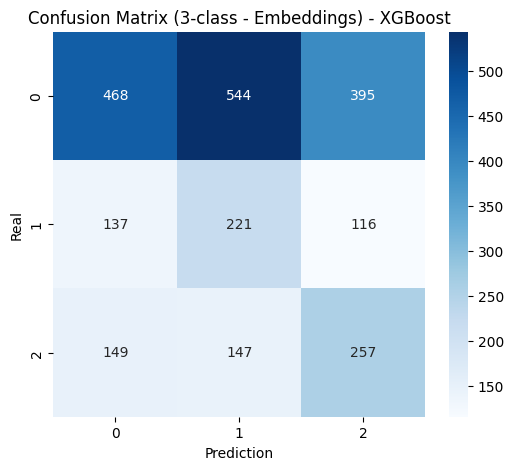

Best model (2-class, TF-IDF): XGBoost, params: {'max_depth': 3, 'n_estimators': 50}
Classification report:
              precision    recall  f1-score   support

           0      0.705     0.800     0.749      1408
           1      0.663     0.540     0.595      1026

    accuracy                          0.690      2434
   macro avg      0.684     0.670     0.672      2434
weighted avg      0.687     0.690     0.684      2434



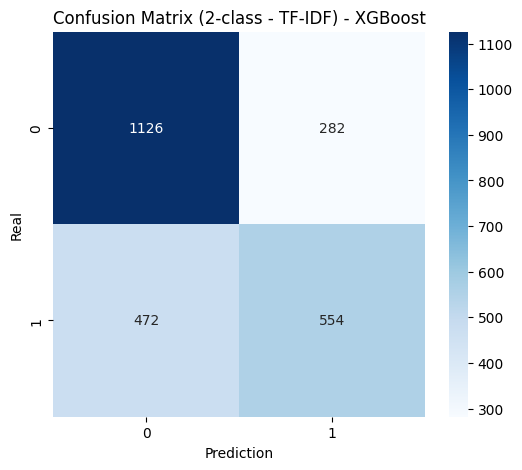

Best model (2-class, Embeddings): XGBoost, params: {'max_depth': 3, 'n_estimators': 50}
Classification report:
              precision    recall  f1-score   support

           0      0.631     0.540     0.582      1408
           1      0.473     0.566     0.516      1026

    accuracy                          0.551      2434
   macro avg      0.552     0.553     0.549      2434
weighted avg      0.564     0.551     0.554      2434



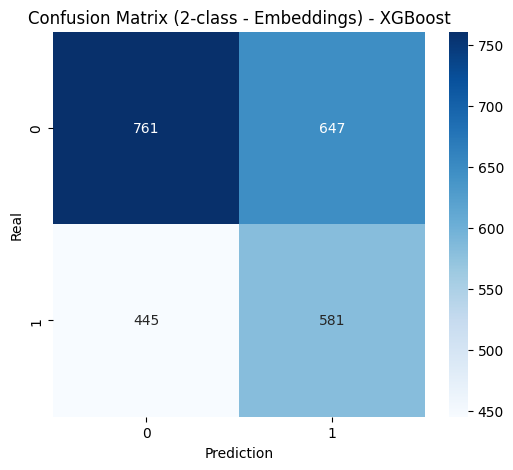

In [31]:
plot_confusion("3-class", X_train_tfidf_3c_res, X_val_tfidf_3c, y_train_3c_res, y_val_3c, "TF-IDF")
plot_confusion("3-class", X_train_embed_3c_res, X_val_embed_3c, y_train_embed_3c_res, y_val_3c, "Embeddings")

plot_confusion("2-class", X_train_tfidf_2c_res, X_val_tfidf_2c, y_train_2c_res, y_val_2c, "TF-IDF")
plot_confusion("2-class", X_train_embed_2c_res, X_val_embed_2c, y_train_embed_2c_res, y_val_2c, "Embeddings")

For the 3-class task, TF-IDF features lead to moderate performance, with overall accuracy of 0.546. Class 0 is predicted with higher precision than recall, while class 1 suffers from low precision despite relatively better recall. 

Using embeddings for the same task significantly reduces performance (accuracy 0.389), with all classes showing lower precision and F1-scores.

For the 2-class task, TF-IDF again outperforms embeddings, reaching 0.690 accuracy. Both classes are predicted more reliably than in the 3-class setup, although class 1 shows slightly lower recall. Embeddings reduce accuracy to 0.551.

The selection identifies the top-performing models for both 3-class and 2-class tasks based on validation accuracy. Depending on embeddings or TF-IDF, the corresponding training datasets are assigned for further use.

In [32]:
best_3c_row = results_df[results_df['label_type'] == "3-class"].sort_values('val_acc', ascending=False).iloc[0]
best_model_3c_name = best_3c_row['model']

best_2c_row = results_df[results_df['label_type'] == "2-class"].sort_values('val_acc', ascending=False).iloc[0]
best_model_2c_name = best_2c_row['model']

X_3c = X_train_embed_3c_res if "Embed" in best_model_3c_name else X_train_tfidf_3c_res
y_3c = y_train_embed_3c_res if "Embed" in best_model_3c_name else y_train_3c_res

X_2c = X_train_embed_2c_res if "Embed" in best_model_2c_name else X_train_tfidf_2c_res
y_2c = y_train_embed_2c_res if "Embed" in best_model_2c_name else y_train_2c_res

### Testing best models for 3 classes

The best model for the 3 class variant is the MLP. The hyperparameter configuration influence the MLP architecture and training process:
- the hidden_layer_sizes parameter tests different network widths, either a single layer of 64 or 128 neurons,
- the activation functions `relu` and `tanh` determine how non-linearities are introduced between layers,
- the solver options `adam` and `sgd` specify the optimization algorithm for updating weights,
- Fixed values for `learning_rate_init`, `alpha`, `batch_size`, and `max_iter` standardize training speed, regularization and convergence.

In [33]:
mlp_3c_params = {
    "hidden_layer_sizes": [(64,), (128,)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [1e-3],
    "alpha": [1e-4],
    "batch_size": [64],
    "max_iter": [100]
}

This function evaluates an MLP model across all combinations of the specified hyperparameters using a parameter grid. Each configuration is trained with early stopping enabled and monites a 10% validation fraction to prevent overfitting.

In [34]:
from sklearn.model_selection import ParameterGrid

def mlp_3c_experiments(X_train, X_val, y_train, y_val):
    grid = list(ParameterGrid(mlp_3c_params))
    results = []
    print(f"\n{len(grid)} configs\n")

    for params in tqdm(grid):
        try:
            model = MLPClassifier(early_stopping=True,n_iter_no_change=10,validation_fraction=0.1,**params)
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            acc = accuracy_score(y_val, pred)
            results.append({
                "params": params,
                "val_acc": acc
            })
        except Exception as e:
            print("Error:", e)

    results = sorted(results, key=lambda x: x["val_acc"], reverse=True)
    print("\nBest config:", results[0])
    return results

The dataset selected for the 3-class MLP experiments is split into training and validation subsets.

In [35]:
X_train_mlp_3c = X_3c
y_train_mlp_3c = y_3c

X_tr, X_val_mlp, y_tr, y_val_mlp = train_test_split(
    X_train_mlp_3c, y_train_mlp_3c, test_size=0.2, random_state=42, stratify=y_train_mlp_3c
)

Function call:

In [36]:
mlp_3c_results = mlp_3c_experiments(X_tr, X_val_mlp, y_tr, y_val_mlp)


8 configs



 38%|███████████████████████████████▌                                                    | 3/8 [01:42<02:54, 34.92s/it]C:\Users\Tygrys\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 62%|████████████████████████████████████████████████████▌                               | 5/8 [05:02<03:19, 66.62s/it]C:\Users\Tygrys\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:16<00:00, 69.53s/it]


Best config: {'params': {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 64, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}, 'val_acc': 0.5813544415127528}


The MLP experiments for the 3-class task evaluated eight different configurations. The best-performing setup used a single hidden layer with 128 neurons, ReLU activation, the Adam optimizer, a learning rate of 0.001, L2 regularization of 0.0001, batch size of 64, and 100 maximum iterations. This configuration achieved a validation accuracy of approximately 0.581.

The selected MLP configuration is trained on the 3-class dataset using standardized features. Early stopping with a 10% validation fraction is also applied.

In [37]:
best_params = mlp_3c_results[0]['params']

scaler = StandardScaler(with_mean=False) if hasattr(X_tr, "toarray") else StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val_mlp)

clf = MLPClassifier(
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    **best_params
)

clf.fit(X_tr_scaled, y_tr)
y_pred = clf.predict(X_val_scaled)

The validation predictions of the MLP model are evaluated using a classification report, summarizing precision, recall, and F1-score for each class.
The confusion matrix visualizes the distribution of correct and incorrect predictions, highlighting which classes are most frequently misclassified.

Classification report:

              precision    recall  f1-score   support

           0      0.456     0.483     0.469       379
           1      0.496     0.449     0.471       379
           2      0.641     0.665     0.653       379

    accuracy                          0.532      1137
   macro avg      0.531     0.532     0.531      1137
weighted avg      0.531     0.532     0.531      1137



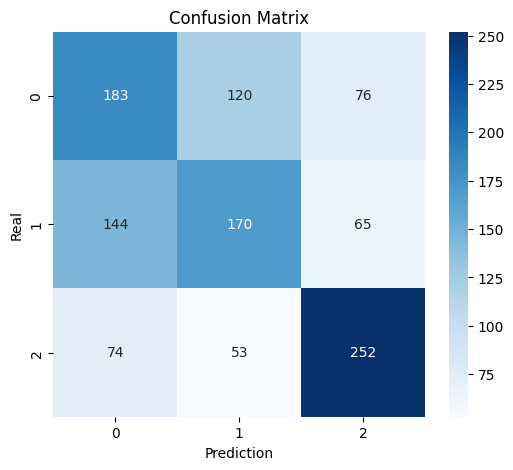

In [38]:
print("Classification report:\n")
print(classification_report(
    y_val_mlp,
    y_pred,
    target_names=[str(c) for c in sorted(np.unique(y_val_mlp))],
    digits=3
))

cm = confusion_matrix(y_val_mlp, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sorted(np.unique(y_val_mlp)),
    yticklabels=sorted(np.unique(y_val_mlp))
)
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

The MLP model for the 3-class task achieved a validation accuracy of 0.532. Class 2 is predicted most effectively, with the highest precision (0.641) and recall (0.665), while classes 0 and 1 show lower but comparable metrics. 

## Conclusions

The table below compares the best models from the experiments.

| Task    | Features   | Best Model | Accuracy |
| ------- | ---------- | ---------- | -------- |
| 3-class | TF-IDF     | XGBoost    | 0.546    |
| 3-class | Embeddings | XGBoost    | 0.389    |
| 2-class | TF-IDF     | XGBoost    | 0.690    |
| 2-class | Embeddings | XGBoost    | 0.551    |
| 3-class | Embeddings | MLP        | 0.532    |


TF-IDF features worked better than embeddings, especially when trying to tell apart three different classes. XGBoost came out on top in almost every case, with both 2- and 3-classes.

The MLP gave acceptable results for the 3-class setup, but it got a bit confused between some classes.

For the 3-class task, the TF-IDF model from `model_exploration` file achieved the highest accuracy, outperforming both our experiments and models using embeddings. Our XGBoost with TF-IDF reached 0.546, which is lower than the simple TF-IDF baseline.

Among embeddings, pretrained GTE-small embeddings with XGBoost gave a moderate result, but still did not surpass the basic TF-IDF approach. The MLP models, whether using embeddings or TF-IDF, generally achieved moderate performance, often predicting class 2 more reliably while struggling with classes 0 and 1.

For the 2-class task TF-IDF delivered the best results. The basic TF-IDF model reached 0.700 accuracy, and our XGBoost with TF-IDF came close at 0.690. Embeddings, both pretrained and frmo our experiments, showed lower accuracy.

To summarize:
- for 3-class classification, the best model is the basic TF-IDF model,
- for 2-class classification, TF-IDF with XGBoost and the basic TF-IDF model works best.